In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
from konlpy.tag import Komoran
import json


##### !필독!

1. py 형태로 바꿔서 import 시키든 그냥 여기서 하던 될껍니다

2. 데이터 셋 형식은 반드시 xlsx 파일로 하시는게 좋습니다. csv나 기타 확장자면 직접 코드 수정하세요

3. 학습 반복 횟수는 적어도 1500번정도는 설정해야됩니다. 안그러면 이상한 대답이 튀어나옵니다

4. 대략 800개 문장을 학습시켰을때 하루 걸렸습니다.(gtx1070, GPU 가속모드 사용)정확도는 0.999, 손실률은 0.001 이하로 나오면 꽤 정확한 문장을 얻을 수 있습니다

5. 팁을 드리자면 질문의 조사등을 바꾸던가 문장 순서를 바꾸던가를 해서 비슷한 질문 : 대답(이건 본래 대답과 똑같이)을 여러개 만드시면 꽤 광범위한 질문들을 커버할 수 있습니다

6. 만약에 가장 긴 질문안에 들어가는 단어의 갯수가 100개 이상이면 max_sequences, 변수를 단어 최대 갯수에 맞게 수정해주세요

7. 정말 귀찮으신 분들을 위해서 AutoStart를 만들어놨습니다. 이거 함수 하나면 학습부터 예측 딕셔너리 설정까지 한큐에 됩니다. 대신 쓸 엑셀파일들은 리스트 형식으로 해주세요 (ex. ['./데이터셋.xlxs', './데이터셋2.xlsx'])

8. 한가지 팁을 더 드리자면 문장안에 들어가는 단어의 갯수가 적으면 적을수록 학습시간이 줄어듭니다. 

9. 파일 구조 - 구조를 지켜주세요.
 - ./dataset/chatbot : 데이터셋을 모으는 저장소
 - EnDecoder : 인코더 파일과 디코더 파일들 저장소
 - json : 인덱스 : 단어 / 단어 : 인덱스 형태의 .json 파일이 저장되는 저장소
 - model : 학습, 예측 모델이 저장되는 저장소
 
 
#### 마지막으로 아래 쓴 함수 순서대로 (위에서 부터 아래) 진행해 주세요 안그럼 설정 오류 날껍니다.


#### 데이터 세트 설정 (형식은 xlxs 파일)
setDataSet()
#### 데이터 세트 konlpy Kommoran으로 품사별 태깅
startPosTag()
#### 대답과 질문 하나로 합치는 과정
setTrainSentences()
#### 인덱스 :  단어 , 인덱스 : 단어 형태의 딕셔너리로 만드는 과정 (산출물 : 해당날짜의 json 파일들)
makeDict()
#### 데이터세트를 encoder와 decoder로 변환.(산출물 : 해당 날짜의 csv 파일들)
makeEnDeCoder()
#### 예측 디코더를 원핫인코딩으로 변환
makeYdecoderToOneHot()
#### 학습 모델 설정 (산출물 : 학습 모델의 .h5파일)
trainModelInit()
#### 예측 모델 설정 (산출물 : 예측 encoder, decoder 의 .h5 파일)
predictModelInit()
#### 학습 시작
startTrain(반복 학습 갯수,학습시킬 데이터 갯수)
#### 예측 문장을 원복시켜주는 함수( 이 함수 사용 이유는 학습시킬때 썼던 문장이 품사별로 태깅된 문장이기에 원래문장으로 원복시켜주는 함수이다)
makeOriginalSentenseDict(학습시켰던 데이터 갯수)

#### 질문을 넣으면 원복된 대답이 나오는 함수
convert_to_originalSentense(질문)

In [4]:
class chatbot:
    PAD = "<PADDING>"   # 패딩
    STA = "<START>"     # 시작
    END = "<END>"       # 끝
    OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)
    # 태그 인덱스
    PAD_INDEX = 0
    STA_INDEX = 1
    END_INDEX = 2
    OOV_INDEX = 3
    # 데이터 타입
    ENCODER_INPUT  = 0
    DECODER_INPUT  = 1
    DECODER_TARGET = 2
    # 한 문장에서 단어 시퀀스의 최대 개수
    max_sequences = 100
    # 임베딩 벡터 차원
    embedding_dim = 100
        # LSTM 히든레이어 차원
    lstm_hidden_dim = 128
        # 정규 표현식 필터
    RE_FILTER = re.compile("[.,!?\"':;~()]")
    dataSet = pd.DataFrame([])
    question = []
    answer = []
    sentences = []
    words = []
    word_to_index = {}
    index_to_word = {}
    x_encoder = np.array([])
    x_decoder = np.array([])
    y_decoder = np.array([])
    v_loss= []
    v_acc= []
    acc= []
    loss = []
    model = None
    encoder_inputs = None
    encoder_states = None
    decoder_inputs = None
    decoder_embedding = None
    decoder_lstm = None
    decoder_dense = None
    encoder_model = None
    decoder_model = None
    originalDict = {}
    
    def setDataSet(self, excelFile):
        # 데이터 셋 집어넣을 때 반드시 컬럼명을 Q, A로 지정해주셔야 합니다.
        # 또한 엑셀파일 전용입니다.
        self.dataSet = self.dataSet.append(pd.read_excel(excelFile,encoding='utf-8'))
        self.question, self.answer = list(self.dataSet['Q']), list(self.dataSet['A'])
    def dataSetClean(self):
        self.dataSet = pd.DataFrame([])
    def setMaxSequences(self,maxSequences):
        self.max_sequences = maxSequences
    def setEmbedding_dim(self, embeddingDim):
        self.embedding_dim = embeddingDim
    # 형태소분석 함수
    def pos_tag(self, sentences):
        # KoNLPy 형태소분석기 설정
        tagger = Komoran()
        # 문장 품사 변수 초기화
        sentences_pos = []
        # 모든 문장 반복
        for sentence in sentences:
            # 특수기호 제거
            sentence = re.sub(self.RE_FILTER, "", sentence)
            # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
            sentence = " ".join(tagger.morphs(sentence))
            sentences_pos.append(sentence)
        return sentences_pos
    def startPosTag(self):
        self.question = self.pos_tag(self.question)
        self.answer = self.pos_tag(self.answer)
    def setTrainSentences(self):
        # 질문과 대답 문장들을 하나로 합침
        self.sentences.extend(self.question)
        self.sentences.extend(self.answer)
        
        # 단어들의 배열 생성
        for sentence in self.sentences:
            for word in sentence.split():
                self.words.append(word)

        # 길이가 0인 단어는 삭제
        self.words = [word for word in self.words if len(word) > 0]

        # 중복된 단어 삭제
        self.words = list(set(self.words))

        # 제일 앞에 태그 단어 삽입
        self.words[:0] = [self.PAD, self.STA, self.END, self.OOV]
    def makeDict(self):
        self.word_to_index = {word: index for index, word in enumerate(self.words)}
        self.index_to_word = {index: word for index, word in enumerate(self.words)}

        with open('./json/' + datetime.today().strftime("%Y%m%d") + '_' + 'word_to_index.json', 'w', encoding="utf-8") as make_file:
            json.dump(self.word_to_index, make_file, ensure_ascii=False, indent="\t")

        with open('./json/' + datetime.today().strftime("%Y%m%d")+ '_' +'index_to_word.json', 'w', encoding="utf-8") as make_file:
            json.dump(self.index_to_word, make_file, ensure_ascii=False, indent="\t")
        # 문장을 인덱스로 변환
    def convert_text_to_index(self, sentences, vocabulary, type): 
        sentences_index = []
        # 모든 문장에 대해서 반복
        for sentence in sentences:
            sentence_index = []
            # 디코더 입력일 경우 맨 앞에 START 태그 추가
            if type == self.DECODER_INPUT:
                sentence_index.extend([vocabulary[self.STA]])

            # 문장의 단어들을 띄어쓰기로 분리
            for word in sentence.split():
                if vocabulary.get(word) is not None:
                    # 사전에 있는 단어면 해당 인덱스를 추가
                    sentence_index.extend([vocabulary[word]])
                else:
                    # 사전에 없는 단어면 OOV 인덱스를 추가
                    sentence_index.extend([vocabulary[self.OOV]])

            # 최대 길이 검사
            if type == self.DECODER_TARGET:
                # 디코더 목표일 경우 맨 뒤에 END 태그 추가
                if len(sentence_index) >= self.max_sequences:
                    sentence_index = sentence_index[:self.max_sequences-1] + [vocabulary[self.END]]
                else:
                    sentence_index += [vocabulary[self.END]]
            else:
                if len(sentence_index) > self.max_sequences:
                    sentence_index = sentence_index[:self.max_sequences]

            # 최대 길이에 없는 공간은 패딩 인덱스로 채움
            sentence_index += (self.max_sequences - len(sentence_index)) * [vocabulary[self.PAD]]

            # 문장의 인덱스 배열을 추가
            sentences_index.append(sentence_index)

        return np.asarray(sentences_index)
    def makeEnDeCoder(self):
        self.x_encoder = self.convert_text_to_index(self.question, self.word_to_index, self.ENCODER_INPUT)
        self.x_decoder = self.convert_text_to_index(self.answer, self.word_to_index, self.DECODER_INPUT)
        self.y_decoder = self.convert_text_to_index(self.answer, self.word_to_index, self.DECODER_TARGET)

        x_en = pd.DataFrame(self.x_encoder)
        x_en.to_csv('./EnDecoder/'+datetime.today().strftime("%Y%m%d") + '_' +'x_encoder.csv')
        x_de = pd.DataFrame(self.x_decoder)
        x_de.to_csv('./EnDecoder/'+datetime.today().strftime("%Y%m%d") + '_' +'x_decoder.csv')
        y_de = pd.DataFrame(self.y_decoder)
        y_de.to_csv('./EnDecoder/'+datetime.today().strftime("%Y%m%d") + '_' +'y_decoder.csv')
    def makeYdecoderToOneHot(self):
        one_hot_data = np.zeros((len(self.y_decoder), self.max_sequences, len(self.words)))
        # 디코더 목표를 원핫인코딩으로 변환
        # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
        for i, sequence in enumerate(self.y_decoder):
            for j, index in enumerate(sequence):
                one_hot_data[i, j, index] = 1

        # 디코더 목표 설정
        self.y_decoder = one_hot_data
        
    def trainModelInit(self):
        self.encoder_inputs = layers.Input(shape=(None,))
        encoder_outputs = layers.Embedding(len(self.words), self.embedding_dim)(self.encoder_inputs)

        # return_state가 True면 상태값 리턴
        # LSTM은 state_h(hidden state)와 state_c(cell state) 2개의 상태 존재
        encoder_outputs, state_h, state_c = layers.LSTM(self.lstm_hidden_dim,
                                                        dropout=0.1,
                                                        recurrent_dropout=0.5,
                                                        return_state=True)(encoder_outputs)

        # 히든 상태와 셀 상태를 하나로 묶음
        self.encoder_states = [state_h, state_c]

        self.decoder_inputs = layers.Input(shape=(None,))

        # 임베딩 레이어
        self.decoder_embedding = layers.Embedding(len(self.words), self.embedding_dim)
        decoder_outputs = self.decoder_embedding(self.decoder_inputs)

        # 인코더와 달리 return_sequences를 True로 설정하여 모든 타임 스텝 출력값 리턴
        # 모든 타임 스텝의 출력값들을 다음 레이어의 Dense()로 처리하기 위함
        self.decoder_lstm = layers.LSTM(self.lstm_hidden_dim,
                                   dropout=0.1,
                                   recurrent_dropout=0.5,
                                   return_state=True,
                                   return_sequences=True)

        # initial_state를 인코더의 상태로 초기화
        decoder_outputs, _, _ = self.decoder_lstm(decoder_outputs,
                                             initial_state=self.encoder_states)

        # 단어의 개수만큼 노드의 개수를 설정하여 원핫 형식으로 각 단어 인덱스를 출력
        self.decoder_dense = layers.Dense(len(self.words), activation='softmax')
        decoder_outputs = self.decoder_dense(decoder_outputs)

        # 입력과 출력으로 함수형 API 모델 생성
        self.model = models.Model([self.encoder_inputs, self.decoder_inputs], decoder_outputs)

        # 학습 방법 설정
        self.model.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])    
        
        self.model.save('./model/'+datetime.today().strftime("%Y%m%d") + '_' + 'model.h5')
    def predictModelInit(self):
        # 훈련 모델의 인코더 상태를 사용하여 예측 모델 인코더 설정
        self.encoder_model = models.Model(self.encoder_inputs, self.encoder_states)

        # 예측시에는 훈련시와 달리 타임 스텝을 한 단계씩 수행
        # 매번 이전 디코더 상태를 입력으로 받아서 새로 설정
        decoder_state_input_h = layers.Input(shape=(self.lstm_hidden_dim,))
        decoder_state_input_c = layers.Input(shape=(self.lstm_hidden_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    

        # 임베딩 레이어
        decoder_outputs = self.decoder_embedding(self.decoder_inputs)

        # LSTM 레이어
        decoder_outputs, state_h, state_c = self.decoder_lstm(decoder_outputs,
                                                         initial_state=decoder_states_inputs)

        # 히든 상태와 셀 상태를 하나로 묶음
        decoder_states = [state_h, state_c]

        # Dense 레이어를 통해 원핫 형식으로 각 단어 인덱스를 출력
        decoder_outputs = self.decoder_dense(decoder_outputs)

        # 예측 모델 디코더 설정
        self.decoder_model = models.Model([self.decoder_inputs] + decoder_states_inputs,
                              [decoder_outputs] + decoder_states)
        self.encoder_model.save('./model/'+datetime.today().strftime("%Y%m%d") + '_' + 'encoder_model.h5')
        self.decoder_model.save('./model/'+datetime.today().strftime("%Y%m%d") + '_' + 'decoder_model.h5')
    def convert_index_to_text(self, indexs, vocabulary): 
    
        sentence = ''

        # 모든 문장에 대해서 반복
        for index in indexs:
            if index == self.END_INDEX:
                # 종료 인덱스면 중지
                break;
            if vocabulary.get(index) is not None:
                # 사전에 있는 인덱스면 해당 단어를 추가
                sentence += vocabulary[index]
            else:
                # 사전에 없는 인덱스면 OOV 단어를 추가
                sentence.extend([vocabulary[self.OOV_INDEX]])

            # 빈칸 추가
            sentence += ' '

        return sentence
    def startTrain(self, epoch, trainCount):
        # 에폭 반복
        sliceNum = int(trainCount / 10)
        x_en = self.x_encoder[:sliceNum]
        x_de = self.x_decoder[:sliceNum]
        y_de = self.y_decoder[:sliceNum]
        for epoch in range(epoch):
            print('Total Epoch :', epoch + 1)
            # 훈련 시작
            history = self.model.fit([self.x_encoder[:trainCount], self.x_decoder[:trainCount]],
                                self.y_decoder[:trainCount],
                                epochs=1,
                                batch_size=128,
                                verbose=1,
                                validation_data=([x_en,x_de], y_de)
                               )

            # 정확도와 손실 출력
            print('accuracy :', history.history['accuracy'][-1])
            print('loss :', history.history['loss'][-1])
            print('val_acc : ', history.history['val_accuracy'][-1])
            print('val_loss : ', history.history['val_loss'][-1])
            self.acc.append(history.history['accuracy'])
            self.loss.append(history.history['loss'])
            self.v_acc.append(history.history['val_accuracy'])
            self.v_loss.append(history.history['val_loss'])

            # 문장 예측 테스트
            # (3 박 4일 놀러 가고 싶다) -> (여행 은 언제나 좋죠)
            input_encoder = self.x_encoder[2].reshape(1, self.x_encoder[2].shape[0])
            input_decoder = self.x_decoder[2].reshape(1, self.x_decoder[2].shape[0])
            results = self.model.predict([input_encoder, input_decoder])

            # 결과의 원핫인코딩 형식을 인덱스로 변환
            # 1축을 기준으로 가장 높은 값의 위치를 구함
            indexs = np.argmax(results[0], 1) 

            # 인덱스를 문장으로 변환
            sentence = self.convert_index_to_text(indexs, self.index_to_word)
            print(sentence)
            print()
            plt.figure(figsize=(25,10))
            plt.subplot(121)
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(self.loss,  label = 'train_loss')
            plt.plot(self.v_loss,  label = 'val_loss')
            plt.legend()

            plt.subplot(122)
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.plot(self.acc,  label = 'train_acc')
            plt.plot(self.v_acc, label = 'val_acc')
            plt.legend()
            plt.show()
    def make_predict_input(self, sentence):

        sentences = []
        sentences.append(sentence)
        sentences = self.pos_tag(sentences)
        input_seq = self.convert_text_to_index(sentences, self.word_to_index, self.ENCODER_INPUT)

        return input_seq
    # 텍스트 생성
    def generate_text(self, input_seq):

        # 입력을 인코더에 넣어 마지막 상태 구함
        states = self.encoder_model.predict(input_seq)

        # 목표 시퀀스 초기화
        target_seq = np.zeros((1, 1))

        # 목표 시퀀스의 첫 번째에 <START> 태그 추가
        target_seq[0, 0] = self.STA_INDEX

        # 인덱스 초기화
        indexs = []

        # 디코더 타임 스텝 반복
        while 1:
            # 디코더로 현재 타임 스텝 출력 구함
            # 처음에는 인코더 상태를, 다음부터 이전 디코더 상태로 초기화
            decoder_outputs, state_h, state_c = self.decoder_model.predict(
                                                    [target_seq] + states)

            # 결과의 원핫인코딩 형식을 인덱스로 변환
            index = np.argmax(decoder_outputs[0, 0, :])
            indexs.append(index)

            # 종료 검사
            if index == self.END_INDEX or len(indexs) >= self.max_sequences:
                break

            # 목표 시퀀스를 바로 이전의 출력으로 설정
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = index

            # 디코더의 이전 상태를 다음 디코더 예측에 사용
            states = [state_h, state_c]

        # 인덱스를 문장으로 변환
        sentence = self.convert_index_to_text(indexs, self.index_to_word)

        return sentence
    
    def makePredictSentense(self,targetSentense):
        return self.generate_text(self.make_predict_input(targetSentense))
    
    def makeOriginalSentenseDict(self, targetSentenseList):
        for sentense in targetSentenseList :
            self.originalDict[self.makePredictSentense(sentense)] = sentense
            
    def convert_to_originalSentense(self, predictSentense):
        sentense = self.makePredictSentense(predictSentense)
        return self.originalDict[sentense]
    
    def AutoStart(self, dataSet, epoch, trainCount):
        for i in dataSet:
            self.setDataSet(i)
        self.startPosTag()
        self.setTrainSentences()
        self.makeDict()
        self.makeEnDeCoder()
        self.makeYdecoderToOneHot()
        self.trainModelInit()
        self.predictModelInit()
        self.startTrain(epoch,trainCount)
        self.makeOriginalSentenseDict(self.dataSet['A'][:trainCount])

In [5]:
cb = chatbot()

In [6]:
dataset = ['./dataset/chatbot/예제.xlsx']

Total Epoch : 1
1/1 [==============================] - 0s 376ms/step - loss: 5.8136 - accuracy: 0.0020 - val_loss: 5.7990 - val_accuracy: 0.0800
accuracy : 0.0020000000949949026
loss : 5.813589572906494
val_acc :  0.07999999821186066
val_loss :  5.798975944519043
의 의 의 의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> 습니다 습니다 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> 습니다 습니다 <PADDING> 아 <PADDING> <PADDING> 적 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDI

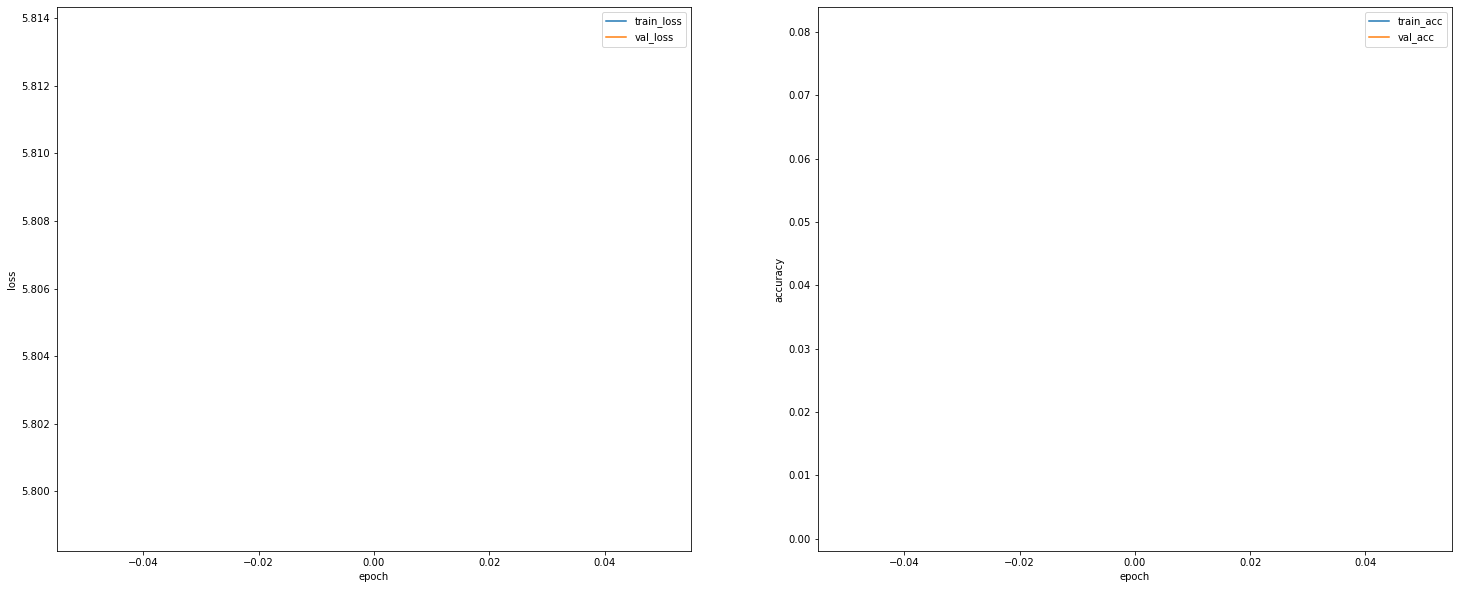

Total Epoch : 2
1/1 [==============================] - 0s 42ms/step - loss: 5.7786 - accuracy: 0.2060 - val_loss: 5.7773 - val_accuracy: 0.0800
accuracy : 0.20600000023841858
loss : 5.778641223907471
val_acc :  0.07999999821186066
val_loss :  5.777296543121338
의 의 의 의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>

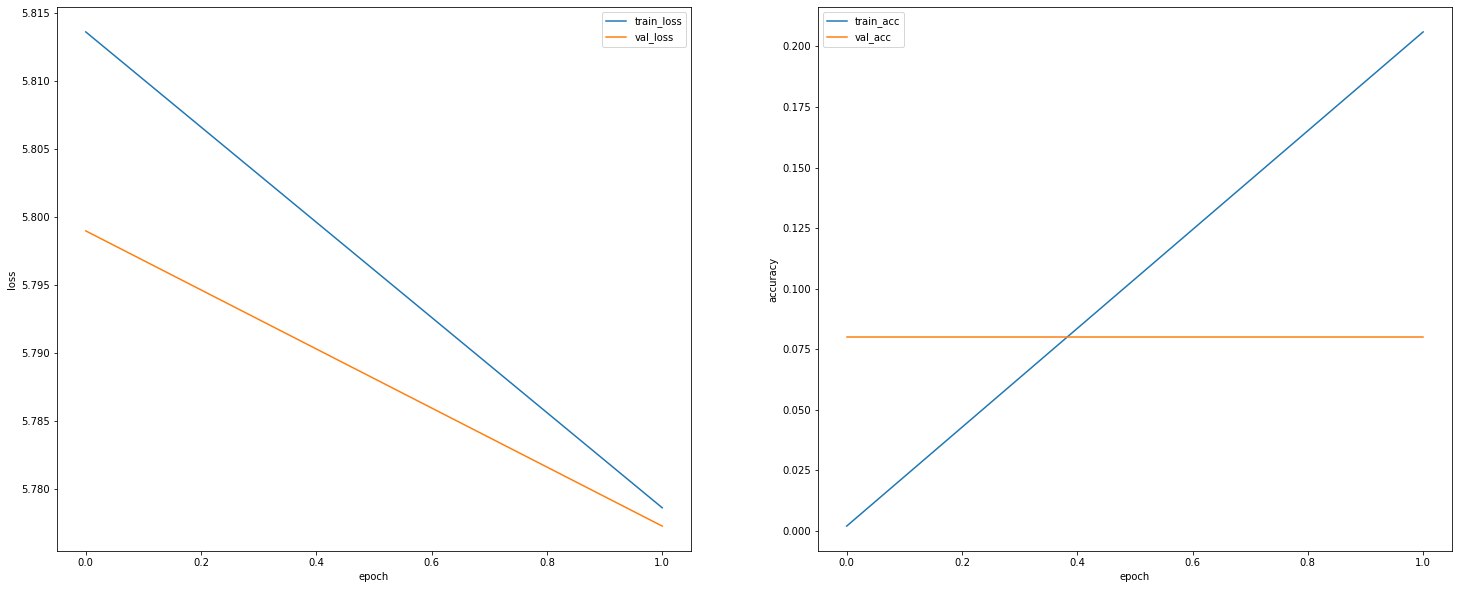

Total Epoch : 3
1/1 [==============================] - 0s 35ms/step - loss: 5.7136 - accuracy: 0.2000 - val_loss: 5.5109 - val_accuracy: 0.0800
accuracy : 0.20000000298023224
loss : 5.713581085205078
val_acc :  0.07999999821186066
val_loss :  5.510865688323975
의 의 의 의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>

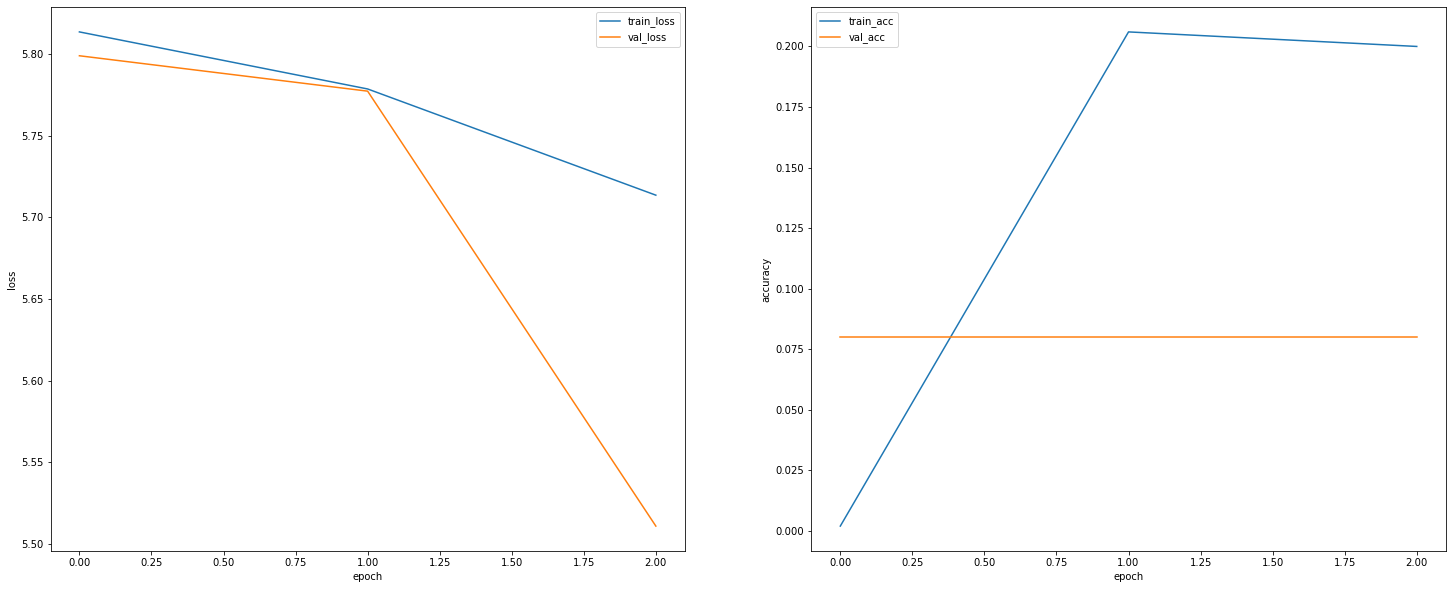

Total Epoch : 4
1/1 [==============================] - 0s 34ms/step - loss: 5.2334 - accuracy: 0.1990 - val_loss: 5.3185 - val_accuracy: 0.0800
accuracy : 0.19900000095367432
loss : 5.23343563079834
val_acc :  0.07999999821186066
val_loss :  5.318485736846924
활동 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDIN

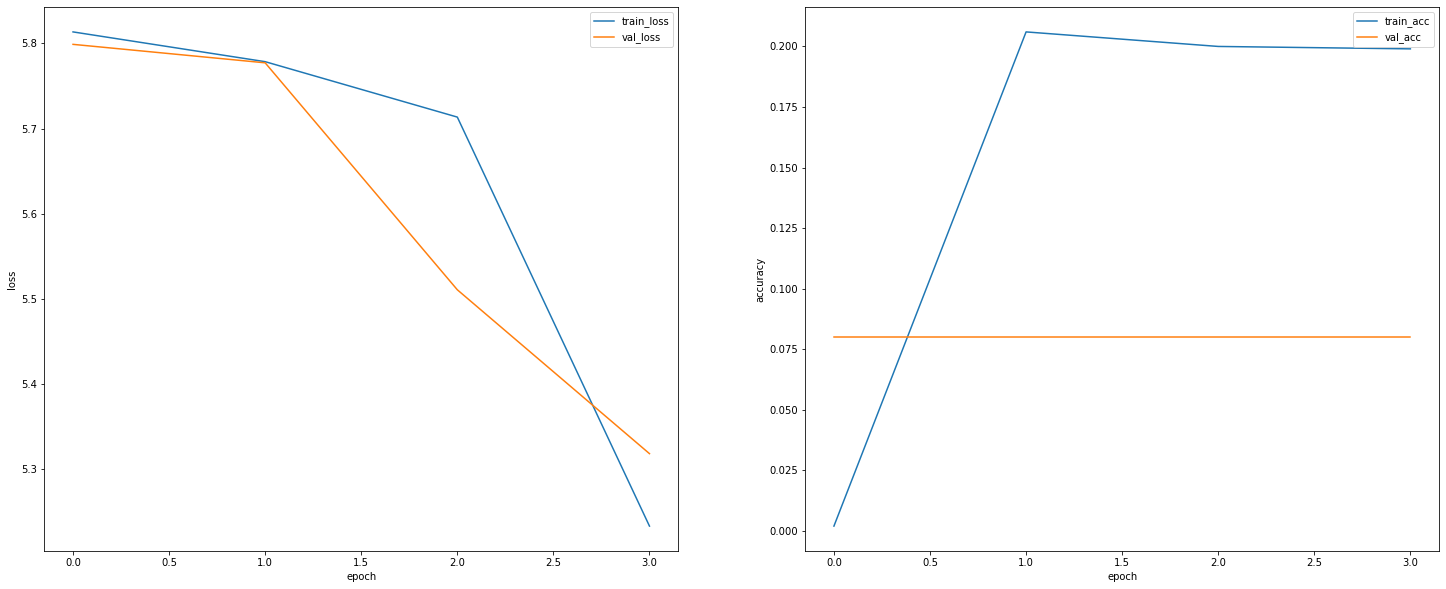

Total Epoch : 5
1/1 [==============================] - 0s 35ms/step - loss: 4.8004 - accuracy: 0.1960 - val_loss: 5.2042 - val_accuracy: 0.0800
accuracy : 0.19599999487400055
loss : 4.800419330596924
val_acc :  0.07999999821186066
val_loss :  5.204227924346924
의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADD

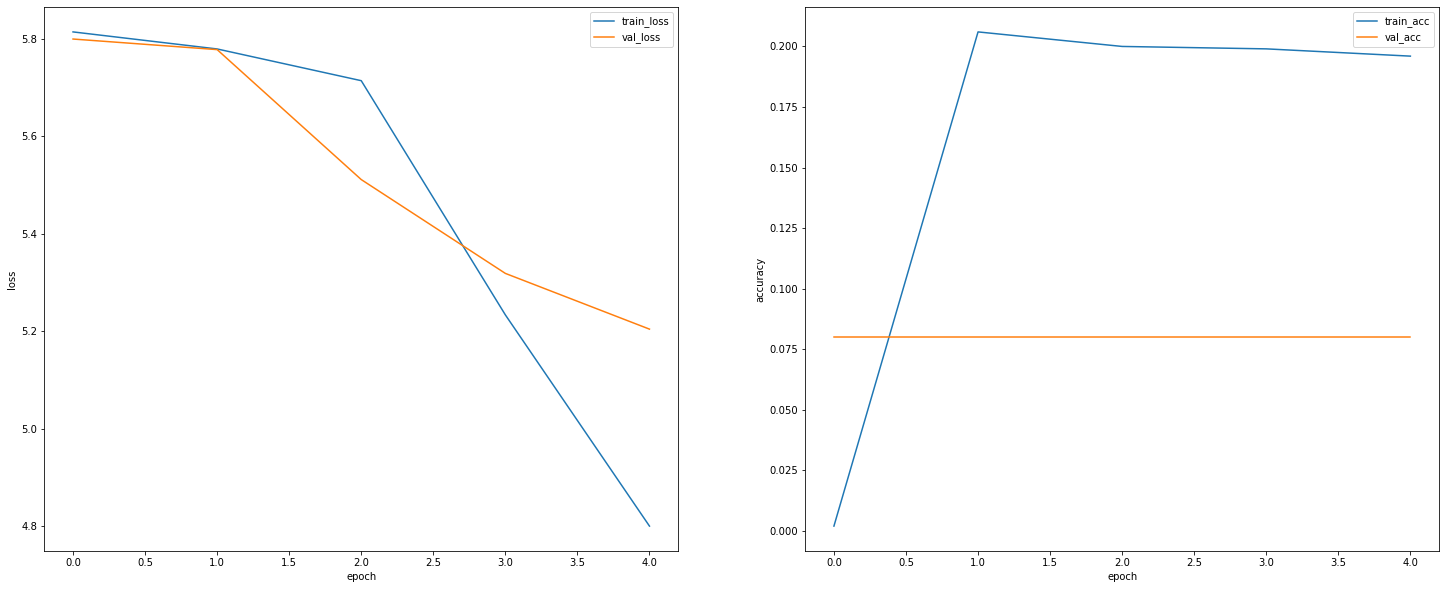

Total Epoch : 6
1/1 [==============================] - 0s 36ms/step - loss: 4.6410 - accuracy: 0.1970 - val_loss: 5.0735 - val_accuracy: 0.0800
accuracy : 0.19699999690055847
loss : 4.6409687995910645
val_acc :  0.07999999821186066
val_loss :  5.073451042175293
5 의 의 활동 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING>

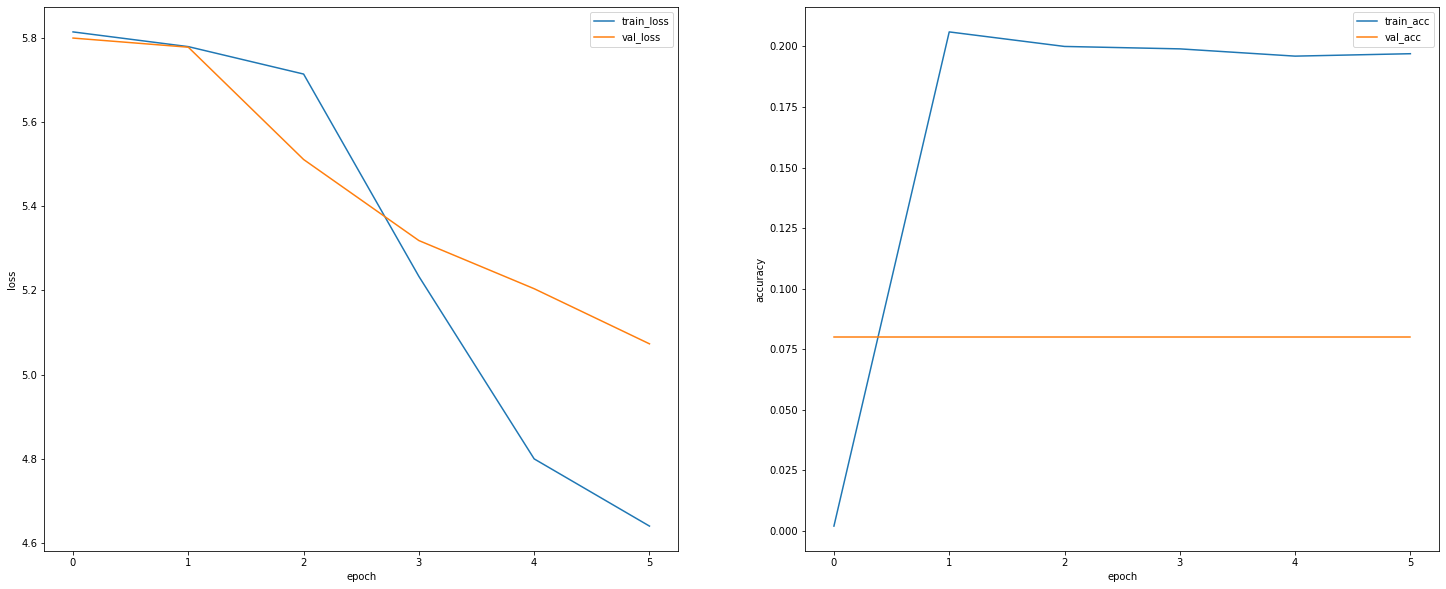

Total Epoch : 7
1/1 [==============================] - 0s 39ms/step - loss: 4.5543 - accuracy: 0.1980 - val_loss: 5.0332 - val_accuracy: 0.0800
accuracy : 0.1979999989271164
loss : 4.554349422454834
val_acc :  0.07999999821186066
val_loss :  5.033184051513672
5 의 의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <P

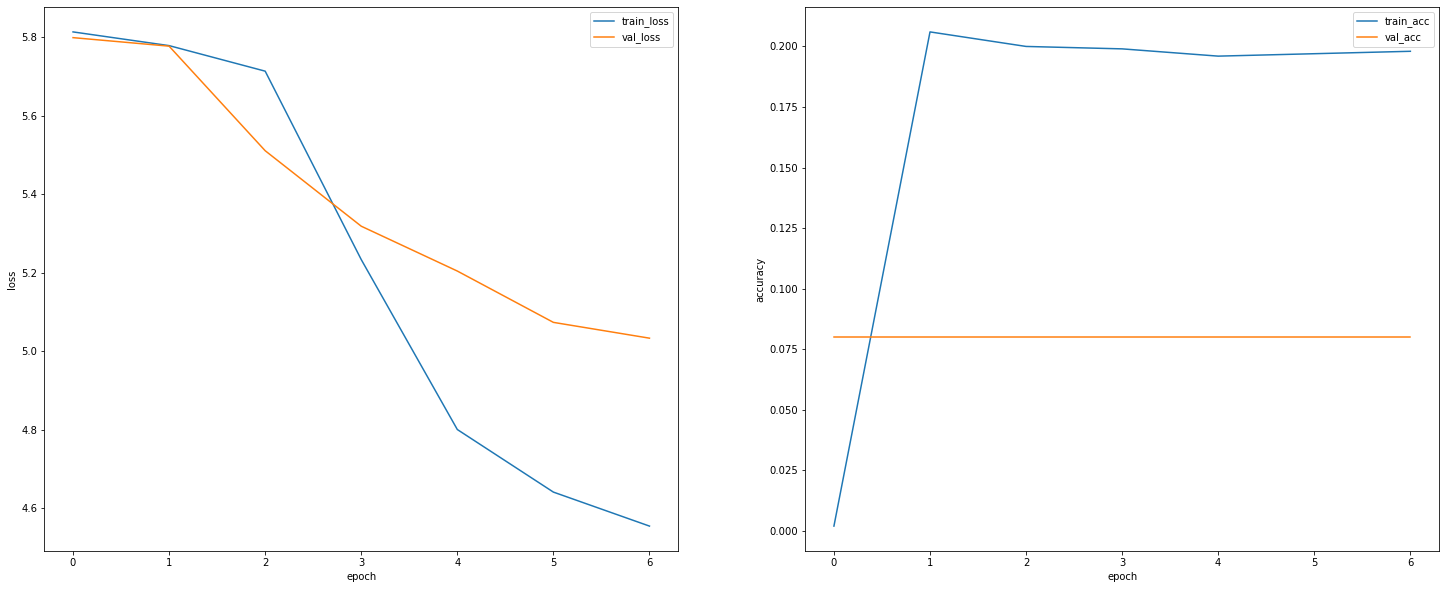

Total Epoch : 8
1/1 [==============================] - 0s 36ms/step - loss: 4.4881 - accuracy: 0.1990 - val_loss: 4.9166 - val_accuracy: 0.0800
accuracy : 0.19900000095367432
loss : 4.488050937652588
val_acc :  0.07999999821186066
val_loss :  4.9165849685668945
5 의 의 의 활동 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDIN

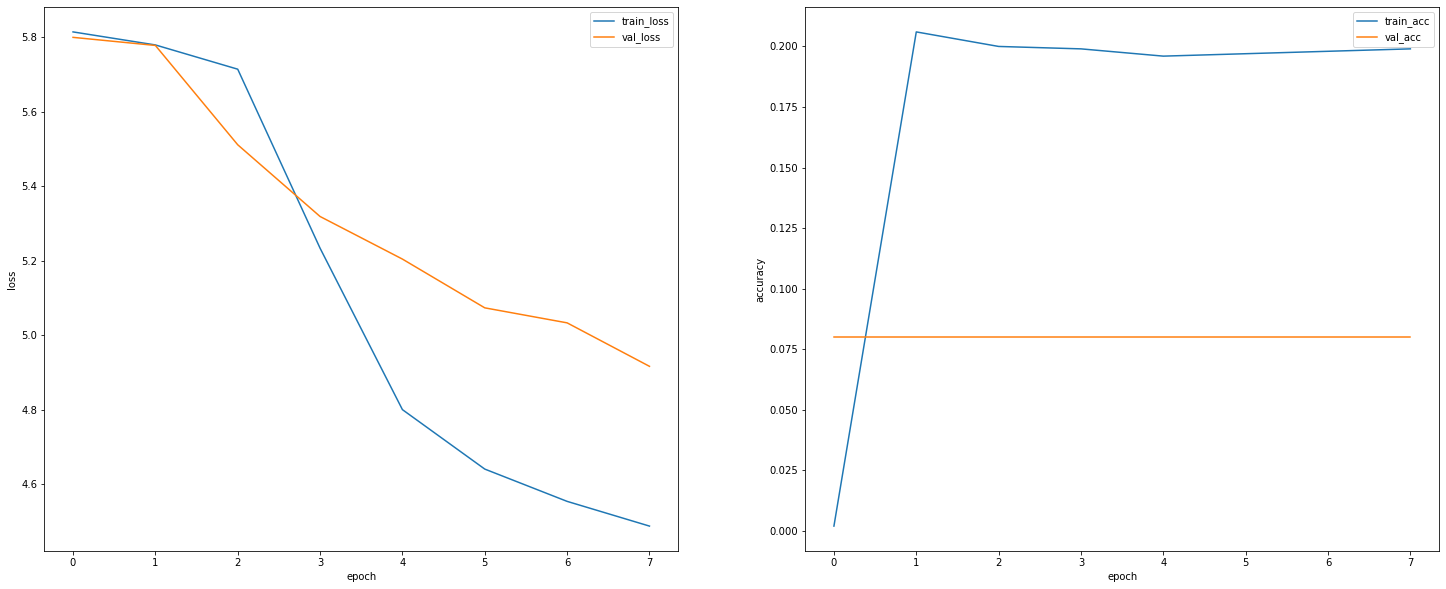

Total Epoch : 9
1/1 [==============================] - 0s 105ms/step - loss: 4.4394 - accuracy: 0.2020 - val_loss: 4.9725 - val_accuracy: 0.0800
accuracy : 0.20200000703334808
loss : 4.43939208984375
val_acc :  0.07999999821186066
val_loss :  4.9724626541137695
5 의 의 의 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> 

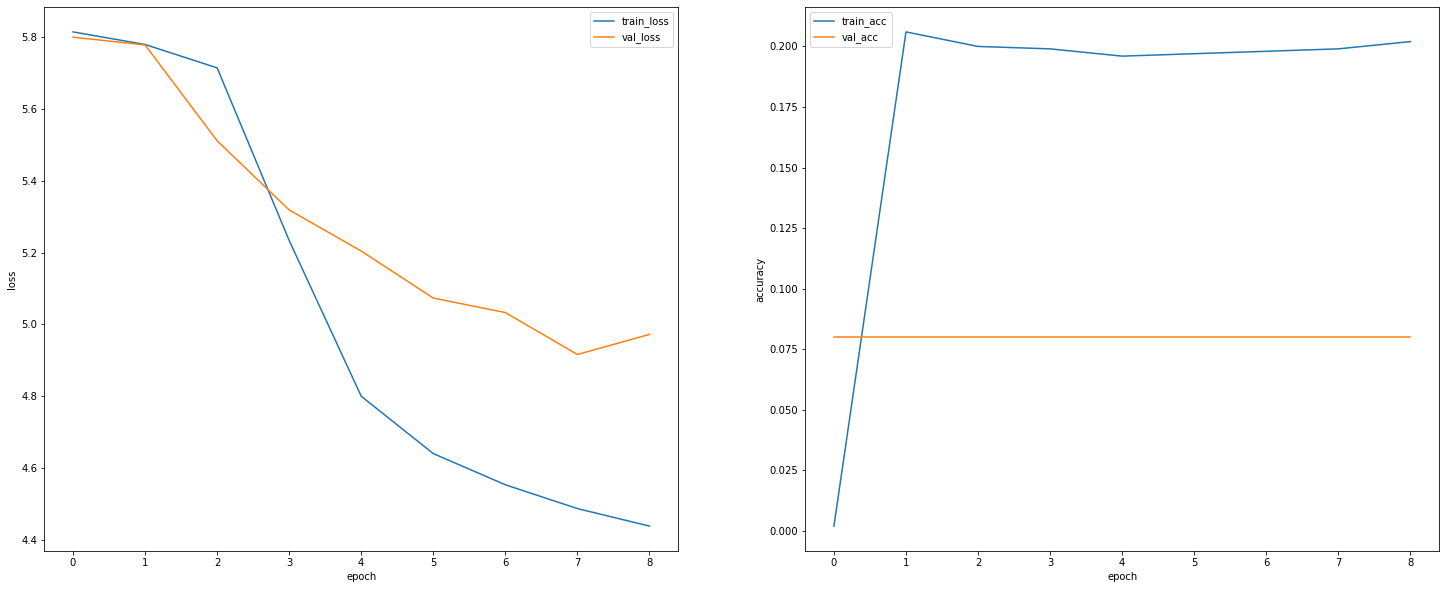

Total Epoch : 10
1/1 [==============================] - 0s 37ms/step - loss: 4.4054 - accuracy: 0.1990 - val_loss: 4.8085 - val_accuracy: 0.0800
accuracy : 0.19900000095367432
loss : 4.405380725860596
val_acc :  0.07999999821186066
val_loss :  4.808495998382568
5 의 의 의 의 의 활동 <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PADDING> <PA

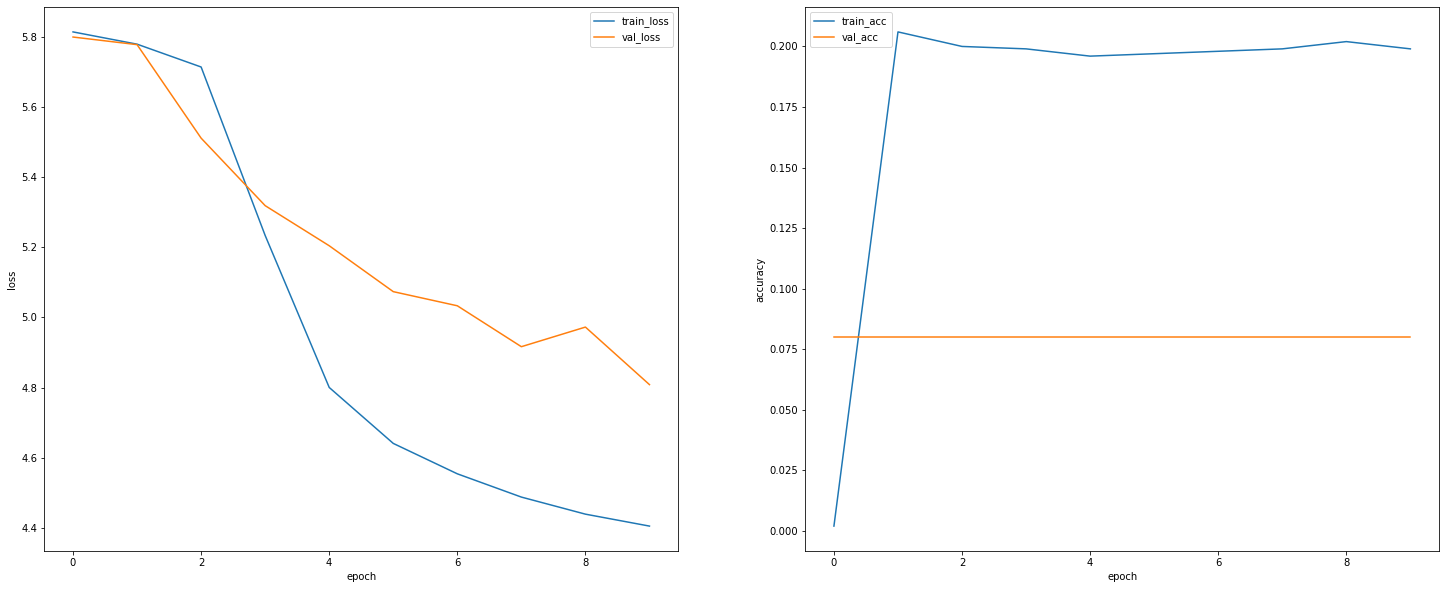

In [8]:
cb.AutoStart(dataset, epoch= 10, trainCount=10)

In [9]:
#학습을 안시켰으니 이상한 결과가 나오는것은 당연합니다...

cb.convert_to_originalSentense('안녕')

'1살 이하 유아: 아기가 엎드린 상태에서 할 수 있는 놀이를 같이 해보세요. 이런 놀이를 아이가 깨어 있을 동안 여러 번 하는 것을 추천합니다.\n'